# Sec 10: Random variables to random vectors to random functions

In this lesson we'll progress through random variables to random vectors to random functions.  We'll find at the end that we've fit our first GP!

## Random variables

You've already learned about random variables, so we won't dwell on this step.  Below we draw 10k samples from a normal random variable.

In [5]:
import arviz as az
import aesara.tensor as at
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import matplotlib.pyplot as plt
import numpy as np

/Users/andre/miniconda3/envs/dev/lib/python3.10/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


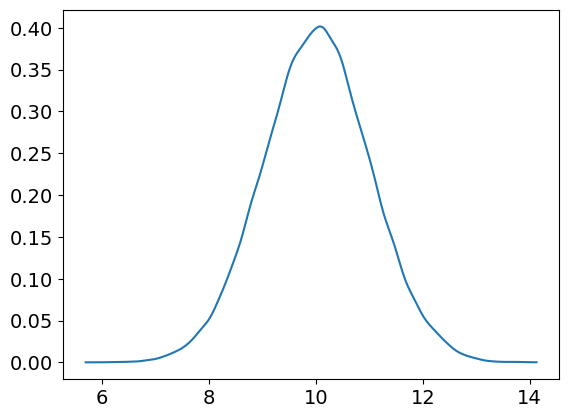

In [6]:
theta = pm.draw(pm.Normal.dist(mu=10, sigma=1), 50_000)

az.plot_dist(theta);

# Now let's generalize to random vectors

In this first example, the distinction between random vector and random variable is just semantic.  A random vector at it's simplest is just random variables stuck together.  

In [7]:
# Make three random variables, put them into a vector
theta1 = pm.Normal.dist(mu=4, sigma=1)
theta2 = pm.Normal.dist(mu=2, sigma=2)
theta3 = pm.Normal.dist(mu=6, sigma=0.5)

# Stick the three random variables together into a random vector
random_vector = [theta1, theta2, theta3]

# Draw samples from the random vector
samples = pm.draw(at.as_tensor_variable(random_vector), draws=10_000)
print("Shape of samples:", samples.shape)

Shape of samples: (10000, 3)


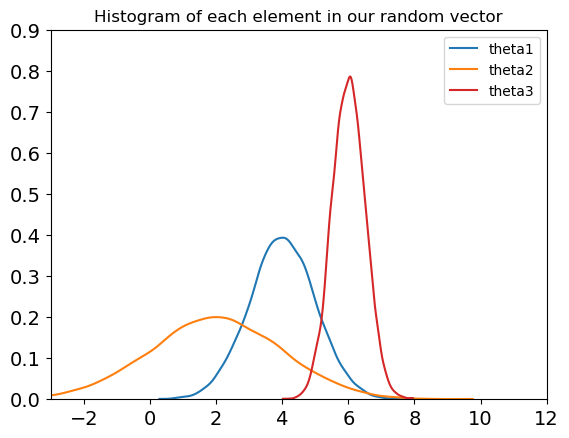

In [8]:
colors = ["C0", "C1", "C3"]

for i in range(3):
    az.plot_dist(samples[:, i], color=colors[i], label="theta" + str(i+1))

plt.title("Histogram of each element in our random vector");
plt.xlim([-3, 12]);
plt.ylim([0.0, 0.9]);

The last example is a trivial case because there is no relationship between the three random variables.  To become a random vector, all we did was stick them together into a list and start thinking about them as something that works together as one "unit".  Usually though, there's not much of a point of talking about random vectors when their random variables have no relationship.  

# Sec 20: Multivariate normals

The most important type of random vector for this course is the multivariate normal.  **A multivariate normal distribution is a set of normal random, like the above example, but, they have correlations between each other -- they are not independent**.  In this section, we are going to intuitively describe multivariate normals.  Like kernels, MvNs are a key building block in Gaussian processes.  They're the "Gaussian" part, after all.  

It's important to start by saying that multivariate normals are a generalization of univariate normals.  Meaning, it's equivalent to describe a set of univariate (like the ones above) distributions as a special type of the multivariate case.

What does this look like?  Let's start with the simplest case.  A two dimensional multivariate normal.  We'll start here because it's possible to visualize it in two dimensions.  Lets plot samples for two normal random variables that are independent on a scatterplot.  

In [25]:
az.plot_pair?

Signature:
az.plot_pair(
    data,
    group='posterior',
    var_names: Optional[List[str]] = None,
    filter_vars: Optional[str] = None,
    combine_dims=None,
    coords=None,
    marginals=False,
    figsize=None,
    textsize=None,
    kind: Union[str, List[str]] = 'scatter',
    gridsize='auto',
    contour: Optional[bool] = None,
    plot_kwargs=None,
    fill_last=False,
    divergences=False,
    colorbar=False,
    labeller=None,
    ax=None,
    divergences_kwargs=None,
    scatter_kwargs=None,
    kde_kwargs=None,
    hexbin_kwargs=None,
    backend=None,
    backend_kwargs=None,
    marginal_kwargs=None,
    point_estimate=None,
    point_estimate_kwargs=None,
    point_estimate_marker_kwargs=None,
    reference_values=None,
    reference_values_kwargs=None,
    show=None,
)
Docstring:
Plot a scatter, kde and/or hexbin matrix with (optional) marginals on the diagonal.

Parameters
----------
data: obj
    Any object that can be converted to an :class:`arviz.InferenceData` 

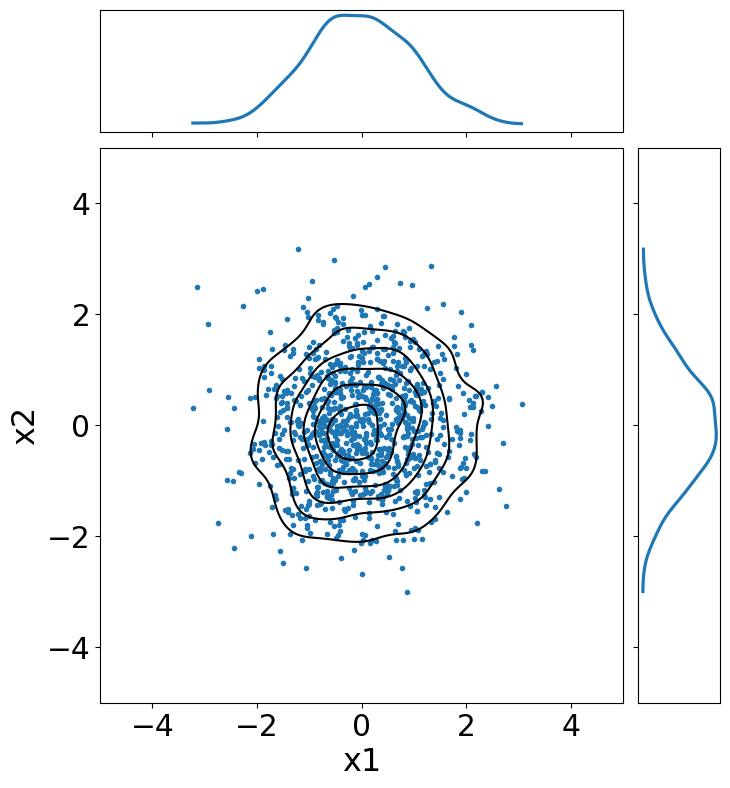

In [29]:
mu = 0.0
sigma = 1.0

x1 = pm.draw(pm.Normal.dist(mu=mu, sigma=sigma), 1000)
x2 = pm.draw(pm.Normal.dist(mu=mu, sigma=sigma), 1000)

axs = az.plot_pair(
    {"x1": x1, "x2": x2},
    kind=["scatter", "kde"],
    marginals=True,
    figsize=(8, 9),
); axs = axs.flatten()

axs[2].set_xlim([-5, 5])
axs[2].set_ylim([-5, 5]);

Notice that I took care to make the figure a square, and to set the axis limits.  Feel free to rerun this code a few times, and draw more samples.  You'll see that the scatter plot always makes a perfect circle -- if you were to sample infinitely of course.  On the top and on the right there are two other plots verifying that this is in fact two, one dimensional normals.  This is the equation for the probability density function for a univariate normal (you've probably seen this before):

$$
p(x \mid \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left[ \frac{(x - \mu)^2}{2\sigma^2} \right]
$$
You may not have noticed that factor of $2\pi$ in the denominator.  $\pi$ is of course, all about circles. There are interesting mathematical connections between normals and circles, but we won't get into that here.  You may find that some people describe multivariate normals as "spherical", or as having some amount of "sphericity".  To show why they say this, let's add a dimension and turn our 2d scatterplot into a 3d scatterplot.

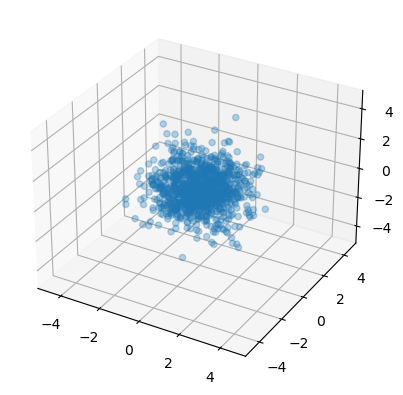

In [30]:
x3 = pm.draw(pm.Normal.dist(mu=mu, sigma=sigma), 1000)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x1, x2, x3, alpha=0.3);

ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5]);
ax.set_zlim([-5, 5]);

### Spheres

Instead of a circle, now it's a sphere!  It's really very difficult to imagine, but try and picture in your mind what this would look like if you added, one more dimension.  You go from a circle in 2d, to a sphere in 3d, to a "sphere" in 4d (you could call it a hypersphere if you want to sound, extra nerdy).  We live in a 3 dimensional world (4 if you count time, which unlike the other three dimensions, seems to only go one way), so I don't want to say it's impossible to picture this round blob in 4 dimensions, because maybe someone out there can, but I can't.  I do think it's important to try though, and to sort of see if you can get a sense of it.

It's an important concept to at least try and wrap your brain around, because spoiler alert: Gaussian processes are actually *infinite* dimensional.  It is important to have some sense of what this means when working with them and developing models with them.  Also, the result of any Bayesian model is actually a high dimensional posterior distribution.  Many hurdles that you face working with real data, flow down from the fact that high dimensional things are difficult to visualize and tricky to deal with.  Even so, having some intuition here means that you can tackle problems and that may have seemed impossible before! 

Thanks for coming to my TED talk.  Since we have work to do and lives to live, let's come back to the mortal plane.  Circles and spheres are cool and all, but let's make make a two dimensional multivariate normal, where there is some dependence between `x1` and `x2`.  You've understand the mean and variance or standard deviation parameters, but we'll need one more parameter, the covariance.  **The covariance parameter describes how strongly two random variables change together -- how much they co-vary**.  Let's draw some samples, show a 2d scatterplot, and then unpack what we're looking at.

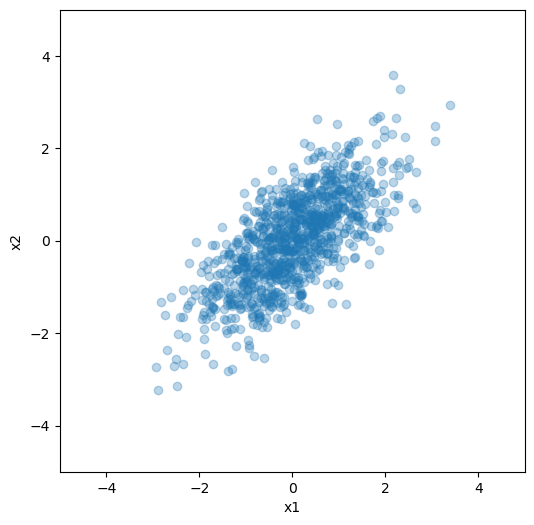

In [31]:
mu = [0.0, 0.0]
sigma1 = 1.0
sigma2 = 1.0
covariance = 0.7
cov = np.array([
    [sigma1, covariance],
    [covariance, sigma2]
])
samples = pm.draw(pm.MvNormal.dist(mu=mu, cov=cov), 1000)

x1 = samples[:, 0]
x2 = samples[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(x1, x2, alpha=0.3)
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5]);
ax.set_xlabel("x1");
ax.set_ylabel("x2");

Instead of a perfect circle, we've now got a diagonal band.  The main new thing you might see here is `cov`.  This is the covariance matrix.  The covariance matrix is a square array of numbers, so there are always an equal number of rows and columns.  There is one row and one column per dimension.  That's why `cov` in this example is two by two.  Each row and each column correspond to one of the dimensions.  

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-0pky"></th>
    <th class="tg-c3ow"><span style="font-weight:bold">Dimension 1</span></th>
    <th class="tg-c3ow"><span style="font-weight:bold">Dimension 2</span></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0pky"><span style="font-weight:bold">Dimension 1</span></td>
    <td class="tg-c3ow">$\sigma^2_{11}$</td>
    <td class="tg-c3ow">$\sigma^2_{12}$</td>
  </tr>
  <tr>
    <td class="tg-0pky"><span style="font-weight:bold">Dimension 2</span></td>
    <td class="tg-c3ow">$\sigma^2_{12}$</td>
    <td class="tg-c3ow">$\sigma^2_{22}$</td>
  </tr>
</tbody>
</table>

If you return to the scatterplot above, you'll see we used the positive value of 0.7.  The fact that this value is positive means, when x1 is large, its more likely that x2 is also large.  Lets cover the left two thirds of the plot:

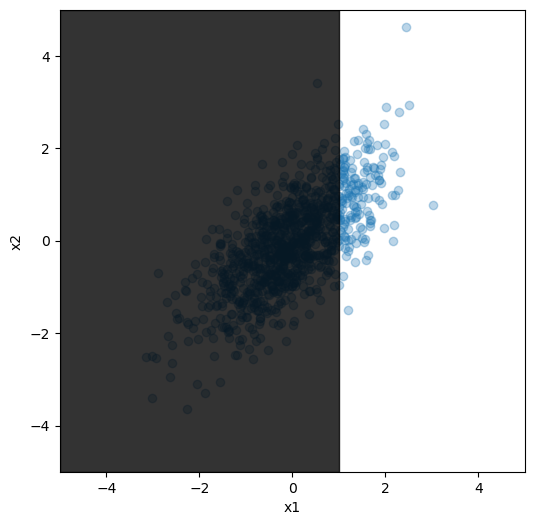

In [8]:
from matplotlib.patches import Rectangle

mu = [0.0, 0.0]
sigma1 = 1.0
sigma2 = 1.0
covariance = 0.7
cov = np.array([
    [sigma1, covariance],
    [covariance, sigma2]
])
samples = pm.draw(pm.MvNormal.dist(mu=mu, cov=cov), 1000)

x1 = samples[:, 0]
x2 = samples[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(x1, x2, alpha=0.3)
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.set_xlabel("x1");
ax.set_ylabel("x2");

ax.add_patch(Rectangle((-5, -5), 6, 10, alpha=0.8, color="k"));

You can see it now, when `x2` is "large", meaning here, above 1, then the points usually are larger values of `x2`.  I'm using the word "usually" on purpose.  Some amount of covariance doesn't guarantee this to be true, it just makes it more likely.  However, the larger values of covariance, the more likely this is true.  To see that this is true, let's take a look at this when the covariance is one, equal to the variance:

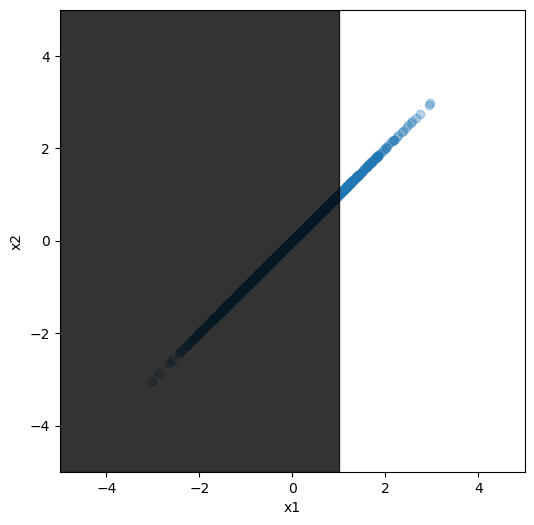

In [9]:
mu = [0.0, 0.0]
sigma1 = 1.0
sigma2 = 1.0
covariance = 1.0 # change this to one.
cov_matrix = np.array([
    [sigma1, covariance],
    [covariance, sigma2]
])
samples = pm.draw(pm.MvNormal.dist(mu=mu, cov=cov_matrix), 1000)

x1 = samples[:, 0]
x2 = samples[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(x1, x2, alpha=0.3)
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.set_xlabel("x1");
ax.set_ylabel("x2");

ax.add_patch(Rectangle((-5, -5), 6, 10, alpha=0.8, color="k"));

When the covariance is equal to the variance, you can see that the word "usually" turns into the word "always".  $x1 = x2$, or, if I tell you what the value of $x1$ is, you'll be able to tell me the value of $x2$. 

The best way to really understand this is to experiment.  Try choosing different values for the mean `mu`, the dimension 1 variance, the dimension 2 variance and the covariance, and then draw and plot the samples.  Here are a few important characteristics that you'll see:

- Increasing the variances stretch the distribution, but only in that particular dimension
- The variances on the diagonal must be positive
- The covariance can be negative or positive
- When you pick covariance values that are larger than the variances, you'll get a long stack trace and some message about the matrix not being positive semi-definite.  This is a mathematical condition that just means you're out of bounds with your choice of covariance.  When you get this error, decrease the value of the covariance that you just increased.

## Practical examples

Think about siblings and height.  Think of 100 pairs of siblings.  If a brother is taller than average, would you guess the sister is also more likely to be taller than average?  It's certainly not a guarantee, but it's probably more likely.  

Also, think about sales at a restaurant.  If there are a lot of customers during the lunch rush, from 12 noon to 1pm.  Are there likely to be a lot of customers in the next hour?  From 1 to 2pm?  The 12 to 1pm customer count is *at least* likely to be more similar to the 1 to 2pm count, than it is to the 3 to 4pm count.

# Sec 30: A different way to visualize multivariate normals: Seeing in N Dimensions

We can't really plot multivariate normal distributions that have more than three dimensions.  Even then, it's really not easy to see what's going on, it just looks like a formless blob of dots.  Let's try a new plot.  Instead of each dimension getting it's own axis, let's plot each dimension down the axis, as if they were sequential points in time.  Here's what I mean, in three dimensions:  

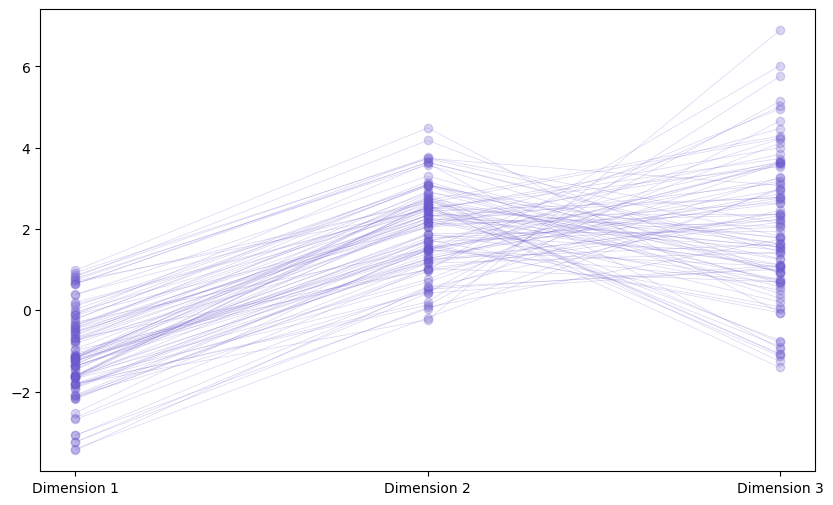

In [10]:
mu = [-1, 2, 2]

sigma1 = 1.0
sigma2 = 1.0
sigma3 = 3.0
covariance12 = 0.8
covariance13 = 0.1
covariance23 = -0.9

cov_matrix = np.array([
    [sigma1, covariance12, covariance13],
    [covariance12, sigma2, covariance23],
    [covariance13, covariance23, sigma3],
])
samples = pm.draw(pm.MvNormal.dist(mu=mu, cov=cov_matrix), 100)

dimension = np.arange(len(mu))

fig, ax = plt.subplots(1, 1, figsize=(10, 6));
ax.plot(dimension, samples.T, color="slateblue", lw=0.5, alpha=0.25, marker="o");
ax.set_xticks(dimension)
ax.set_xticklabels(["Dimension " + str(i) for i in dimension + 1]);

What does covariance look like in this context?

- When you go from dimension 1 to dimension 2, consider the value of `covariance12`.  It's positive, and the lines basically never cross each other. As the value in dimension one increases, so does the value in dimension 2.
- Look at dimension 2 to 3, and consider the value of `covariance23`.  It's negative, and basically every line crosses.  If it's relatively high in dimension 2, it goes down and is low in dimension 3, and visa versa. 
- What about `covariance13`?  It's here, but it's invisible in this plot.  It's doing something similar to `covariance12` and `covariance13`.  But, that's the thing about projecting a higher dimensional thing down into a lower dimensional space.  Things in higher dimensions do have real effects, but these effects are invisible from lower dimensional viewpoints.  The effects they produce are real, but the mechanism isn't apparent. 

Again, I encourage you to play with the numbers here and see what happens.  Nothing is stopping us from making this type of plots in even higher dimensions, even hundreds or thousands of dimensions is possible.  We'll make plots of Gaussian proceses that look like this many many times in this course!

## Multivariate normal wrap-up

The amount of knowledge out there on normal and multivariate normals is pretty vast.  A quick skim of the wikipedia page will tell you as much.  For now though, we'll redirect ourselves back towards building a Gaussian process.  We will return to multivariate normals in a later lesson after we fit our first GPs.  Multivariate normals are important because of two other key concepts, **marginalization** and **conditioning**.  

# Sec 40: Remember kernels?

What if we used a kernel to generate the covariance matrix for a multivariate normal?  Remember the main takeaway from that lesson, kernel functions give the similarity of the points in $y$, depending on the points $x$ and $x'$.  *Isn't this kind of the same thing as the covariances bwetween elements in a multivariate normal?*  

Let's try it out.  Let's take our same exponentiated quadratic kernel from Art class, use it to calculate a 10 by 10 covariance matrix, and use it to draw samples from a multivariate normal.  

In [11]:
# Copy/paste our kernel function from the art class lesson
def kernel(x, x_prime, lengthscale):
    return np.exp( -0.5 * np.square(x - x_prime) / np.square(lengthscale))

x = np.arange(10)

# Calculate kernel/covariance matrix values for every possible pair of x values in the data
K = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        K[i, j] = kernel(x[i], x[j], lengthscale=2)
        
# Lets use a zero mean this time
mu = np.zeros(10)
    
# Draw samples from this random vector
random_vector = pm.MvNormal.dist(mu=mu, cov=K)
samples = pm.draw(random_vector, draws=10_000)

This is another example of a random vector where there are relationships between the different X's.  And of course, these relationships are determined by the kernel matrix.  

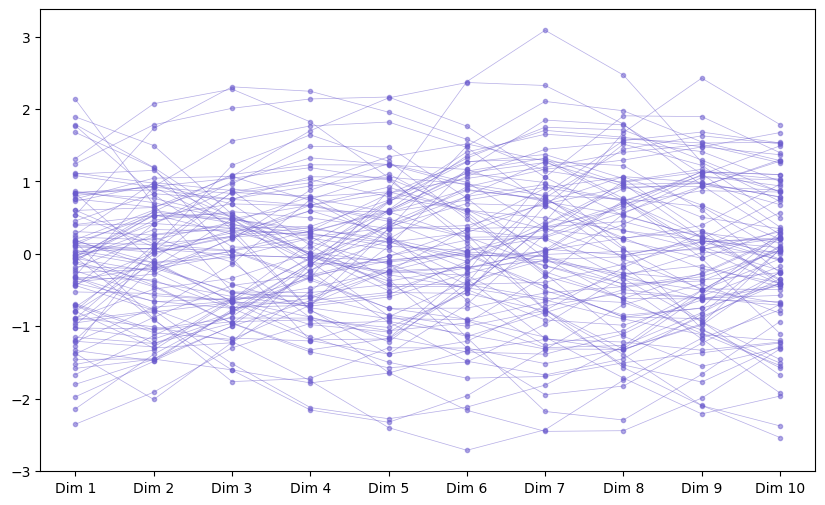

In [12]:
x = np.arange(len(mu))
fig, ax = plt.subplots(1,1,figsize=(10, 6))

# plot 100 of the samples
ix = np.random.randint(0, samples.shape[0], 100)
ax.plot(x, samples[ix, :].T, color="slateblue", lw=0.5, alpha=0.5, marker=".")

ax.set_xticks(x);
ax.set_xticklabels(["Dim " + str(i + 1) for i in range(len(x))]);

There's a very important quality to notice here, **smoothness**.  Just like in art class, the changes from point to point as we go from left to right are smooth.  Except now, we have multivariate normals in our toolbelt.  The combination of a kernel and a multivariate normal are the two primary ingredients in a Gaussian process.

# Sec 50: ... so can we use this distribution as a prior?

Yes!  We certainly can.  There's no reason priors have to be one dimensional.  The Bayesian approach is all about **generative** modeling. What this means, is that we think about how our data was generated.  This might be the most important concept to take home from this course.  

- **We assume our data was generated by a high dimensional multivariate normal**.  
- **Every point in the $x$ axis, is one dimension of the multivariate normal.**
- **Priors that describe **smoothness** are key to building good models.**

So now let's generate some fake data and try it out.  Here's our example dataset.  It's binary data, or binary classification.  To make it a bit more interesting, we'll generate data with a increase, a dip, and another increase.  There are a lot of cases we could imagine working like this.  For instance, this may represent the amount of time spent on website and probability of checking out.  People who spend little time may have arrived with the intention to buy.  People who browse for a long time may have arrived with the intention to buy, but just didn't know which one.  People who poke around for a little while may be the least likely to make a purchase. 

This is somewhere where we might first think to apply a logistic regression, or since there's a non-linear effect we wish to capture, perhaps a random forest classifier.  But since this is Intuitive Bayes, we'll build a Bayesian model. 

There is one input here, `x`.  The probability of the positive class.  It starts is high, then goes low, then high again as x increases.

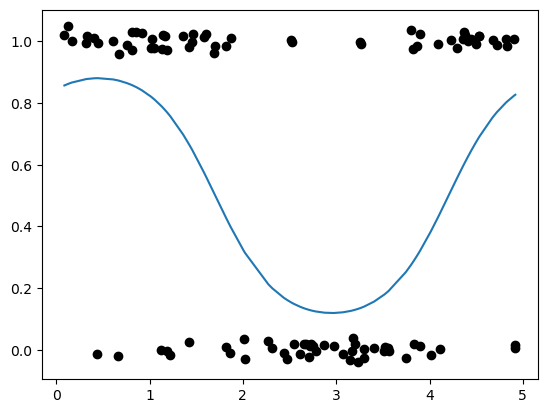

In [29]:
x = 5 * np.sort(np.random.rand(100))
p_true = at.sigmoid( 2 * np.sin(2 * np.pi * x * 0.2 + 1.0 )).eval()
y = np.random.binomial(1, p=p_true)

jitter = 0.02 * np.random.randn(len(x))
plt.plot(x, y + jitter, "ok");
plt.plot(x, p_true);

In [30]:
import pymc.sampling_jax

In [31]:
## model 1
N = len(x) # number of data points
with pm.Model() as model:
    
    # scale the variance of the prior
    eta = pm.HalfNormal("eta", sigma=1)
   
    # A multivariate normal random vector prior, with no correlation between elements
    mu = np.zeros(N)
    cov = eta**2 * np.diag(np.ones(N))
    f = pm.MvNormal("f", mu=mu, cov=cov)
    
    p = at.sigmoid(f)
    lik = pm.Bernoulli("lik", p=p, observed=y)

with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(target_accept=0.9)

Compiling...
Compilation time =  0:00:01.266709
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:57.532627
Transforming variables...
Transformation time =  0:00:00.007068
Computing Log Likelihood...
Log Likelihood time =  0:00:00.182551


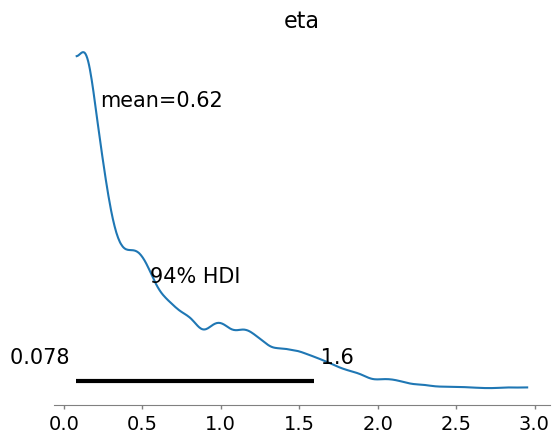

In [32]:
az.plot_posterior(idata, var_names=['eta']);

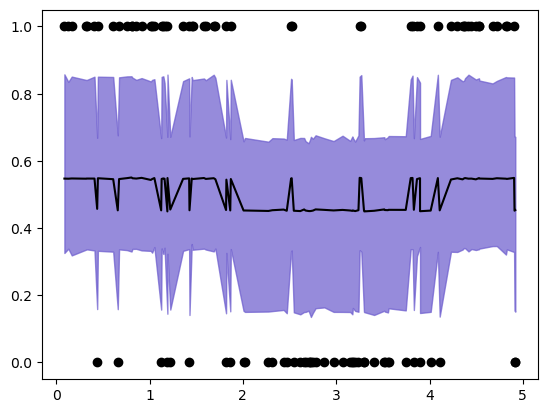

In [33]:
f = idata.posterior.f.stack(samples=['chain', 'draw']).values
p = at.sigmoid(f).eval()

plt.fill_between(x, np.percentile(p, 5, axis=1), np.percentile(p, 95, axis=1), edgecolor="k", color="slateblue", alpha=0.7)
plt.plot(x, np.mean(p, axis=1), color="k");
plt.plot(x, y, "ok");

We can see that's it's not really representing the data well.  `p` is kind of higher on the left and right, but not really.  There's also a lot of uncertainty.  Not to anthropomorphize, but our model doesn't know that data points that are near by in terms of $x$, should also be nearby in terms of $p$.  It would take a lot more than 100 data points for the model to learn this relationship.  

So let's help it along.  Let's give the model a nudge in this direction by including this correlation in our prior.  We know that data points that are nearby in terms of $x$, should also be nearby in terms of $p$.  We don't know by how much though.  We can use kernels to parameterize these relationships though!  Remember the lengthscale parameter?  We don't know it, but we can put a prior on it.  

In [34]:
## model 2
N = len(x) # number of data points
with pm.Model() as model:
    
    # scale the variance of the prior
    eta = pm.HalfNormal("eta", sigma=10)

    # A multivariate normal random vector prior, with correlation between the inputs
    # We're using the pm.gp.cov.ExpQuad function in PyMC, which implements basically 
    # the same code that we wrote earlier in our function called "kernel".  You should
    # use it though, because extra care has gone into testing it and making it numerically
    # stable.
    lengthscale = pm.Uniform("lengthscale", lower=1, upper=5)
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=lengthscale)
    
    K = cov_func(x[:, None])
    
    ## This is the non-centered parameterization of a multivariate normal
    # without it, you wouldn't be able to sample from a GP.  This is an implementation
    # trick you need to do to make this work properly.  There are actually two implementation
    # tricks here, the second being adding a very small diagonal to the kernel matrix K.
    K = at.linalg.cholesky(K + 1e-6*at.identity_like(K))
    v = pm.Normal("v", mu=0.0, sigma=1.0, size=len(x))
    f = at.dot(K, v)

    p = pm.Deterministic("p", pm.math.sigmoid(f))
    lik = pm.Bernoulli("lik", p=p, observed=y)

with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(target_accept=0.9)

Compiling...
Compilation time =  0:00:02.283281
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:02:09.222290
Transforming variables...
Transformation time =  0:00:01.705686
Computing Log Likelihood...
Log Likelihood time =  0:00:01.554924


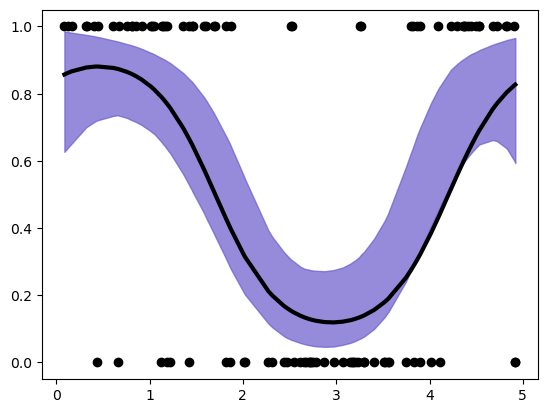

In [35]:
p = idata.posterior.p.stack(samples=['chain', 'draw']).values

plt.fill_between(x, np.percentile(p, 5, axis=1), np.percentile(p, 95, axis=1), edgecolor="k", color="slateblue", alpha=0.7)
plt.plot(x, p_true, color="k", lw=3);
plt.plot(x, y, "ok");

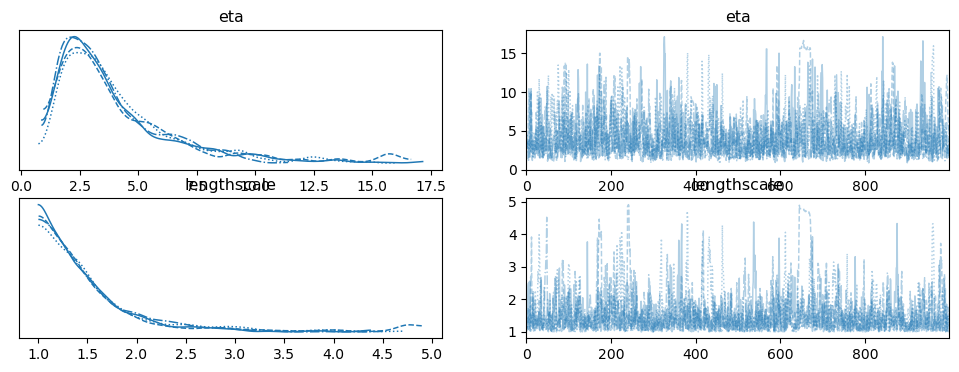

In [36]:
az.plot_trace(idata, var_names=["eta", "lengthscale"]);

## Things look great!  But something is not quite right here.

To see, let's plot this a little differently.  We'll plot the same posterior samples but with dots instead of lines:

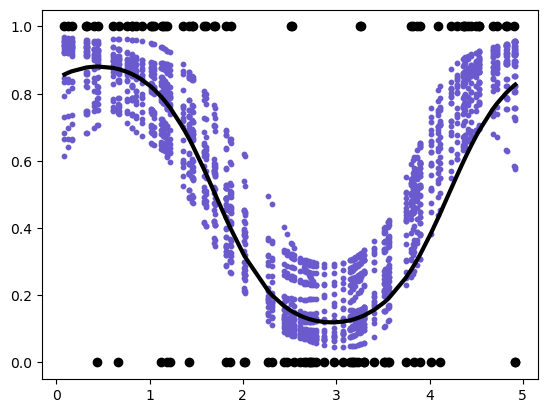

In [37]:
p = idata.posterior.p.stack(samples=['chain', 'draw']).values

#plt.fill_between(x, np.percentile(p, 5, axis=1), np.percentile(p, 95, axis=1), edgecolor="k", color="slateblue", alpha=0.7)
ix = np.random.randint(0, p.shape[1], 20)
for i in range(len(ix)):
    plt.scatter(x, p[:, i], color="slateblue", s=10);
plt.plot(x, p_true, color="k", lw=3);
plt.plot(x, y, "ok");

Here's the problem.  **We are only able to predict at the observed data points**.  You'll notice that the dimensionality of the prior is exactly the same as the data.  We really have a random vector here, not a random function.  In the next section, we'll show how we can combine the two facts that the covariance function is an actual function, and the number of dimensions of multivariate normals is somewhat flexible, to finally unveil Gaussian processes.

# Sec 60: Random functions

We *almost* have a GP, we are so close!  There is one last piece of the puzzle still remaining.  You might have noticed that we haven't used our model to make a forecast, or to interpolate between the $x$ points (or equivalently, the multivariate normal dimensions).  The concept of a random vector doesn't include ways to interpolate between it, or extend it out further by adding more random variables.  

Remember that function is a mathematical object, or a box, where you can give it an input, or an $x$ value (from the domain the function is defined over), and out from the other side comes some output value.  

- What happens when you draw a sample from a random variable?  You get a value, one sample.
- What happens when you draw a sample from a random vector?  You get a vector.  Your sample is one of many possible sets of values.

## Finally, what happens when you draw samples from a random function?

You get

In [23]:
x = np.linspace(0, 10, 200)
cov = pm.gp.cov.ExpQuad(1, ls=2)
K = cov(x[:, None]).eval()
s = pm.draw(pm.MvNormal.dist(mu=np.zeros(200), cov=K), 25)

this

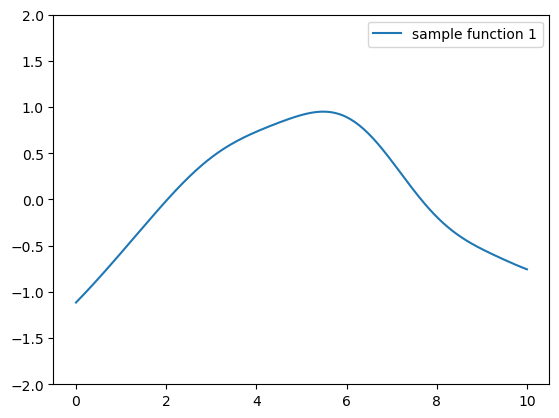

In [24]:
plt.plot(x, s[0, :], color="C0", label="sample function 1");
plt.ylim([-2, 2]);
plt.legend();

and this

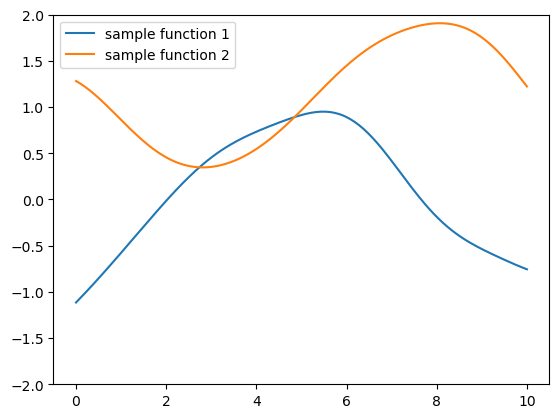

In [25]:
plt.plot(x, s[0, :], color="C0", label="sample function 1");
plt.plot(x, s[1, :], color="C1", label="sample function 2");
plt.ylim([-2, 2]);
plt.legend();

and then this

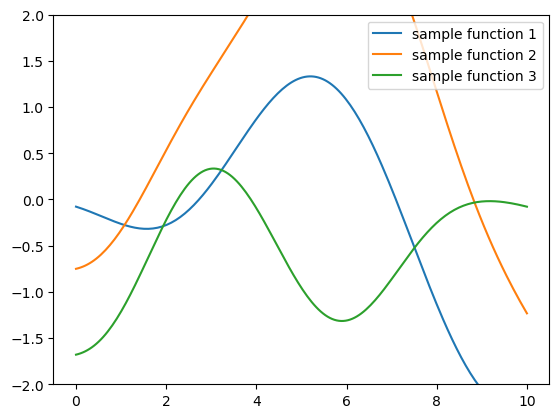

In [67]:
plt.plot(x, s[0, :], color="C0", label="sample function 1");
plt.plot(x, s[1, :], color="C1", label="sample function 2");
plt.plot(x, s[2, :], color="C2", label="sample function 3");
plt.ylim([-2, 2]);
plt.legend();

Here are many many samples

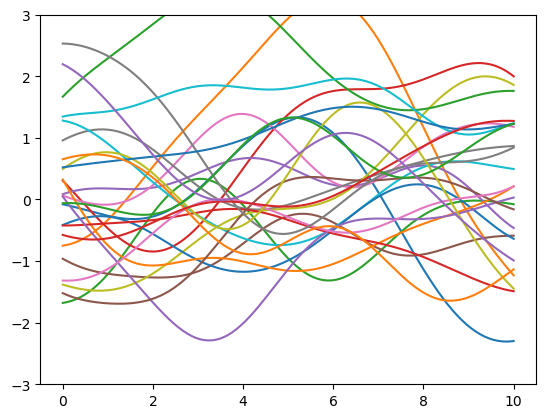

In [68]:
plt.plot(x, s.T);
plt.ylim([-3, 3]);

Unlike a random vector, all of these different paths are functions.  Yes, if we plotted these as dots we'd see that these aren't perfectly smooth lines, BUT, we could plug in more x's wherever we want (functions!) and all the lines would smoothly extend out past 10.

- A normal distribution is an example of a probability distribution over values
- A multivariate normal distribution is an example of a probability distribution over vectors
- **A Gaussian process** is an example of a probability distribution over functions

The key to this whole thing is the covariance function we built before, $k(x, x)'$  Since it's a function of $x$, *and* we can use it as a covariance in a multivariate normal, it allows us to convert the *dimensions* of the multivariate normal, into points on $x$.  

The line between a random vector and a random function may seem a little blurry too, but it's really not.  If you observe 5 points along a random function, so only 5 x locations, is that a length 5 random vector? Sure, it is.   

### Section 60

Before we move on, let's solidify this concept by looking at two more different distributions over functions.

Here are sample functions from a distribution over functions that are a bit shakier and can wander around, but hover around a mean of 5:

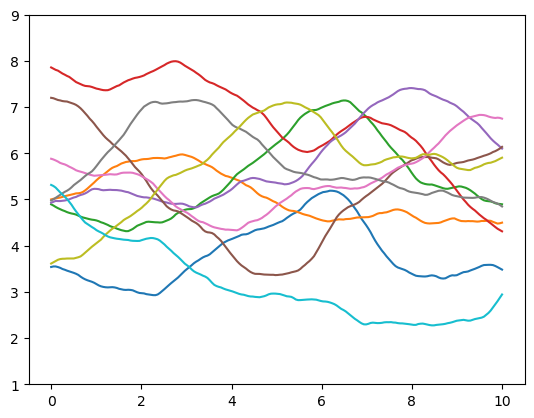

In [69]:
x = np.linspace(0, 10, 200)
cov = 2.0 * pm.gp.cov.Matern32(1, ls=4)
K = cov(x[:, None]).eval()
s = pm.draw(pm.MvNormal.dist(mu=5*np.ones(200), cov=K), 10)

plt.plot(x, s.T);
plt.ylim([1, 9]);

And now here are samples from a distribution over functions that repeat themselves -- but aren't restricted to being perfect sine waves:

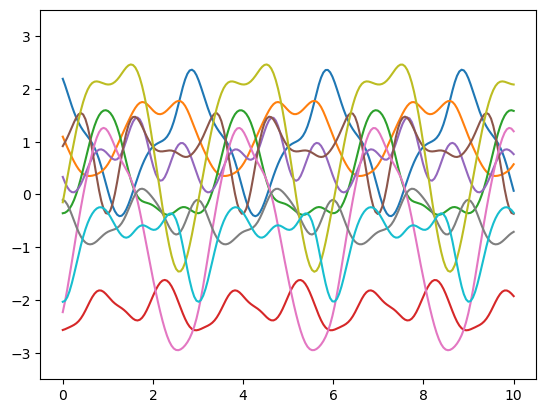

In [70]:
x = np.linspace(0, 10, 200)
cov = pm.gp.cov.Periodic(1, period=3, ls=0.5) + 1.0
K = cov(x[:, None]).eval()
s = pm.draw(pm.MvNormal.dist(mu=np.zeros(200), cov=K), 10)

plt.plot(x, s.T);
plt.ylim([-3.5, 3.5]);

# Sec 70: Gaussian processes

Alright, here it is.  A GP is usually written down as,

$$
f(x) \sim \mathcal{GP}\left(0\,, k(x, x')\right) \,.
$$

Read this as: "The function f(x) is distributed as a Gaussian process with mean zero and covariance function $k(x, x')$.  If we take a fixed set of $x$ values and plug them in, it becomes a multivariate normal random vector.  But before that, since the kernel $k$ is a function over $x$ and $x'$, we have a distribution over functions.  Since there are an infinite number of $x$ values you could plug in (because $x$ can be any number, right?), people say that GPs are an infinite dimensional distribution.  

When we plug in some $x's$, we get a multivariate normal random vector, with elements for each $x$ we plugged in.

$$
\mathbf{f}_x \sim \mathcal{N}\left(0\,, \mathbf{K}_{xx}\right) \,.
$$

We've seen lot's of examples of this already!  Here's some code you've already seen, but now with some annotations.  We are drawing samples from a Gaussian process prior.

## GP Prior

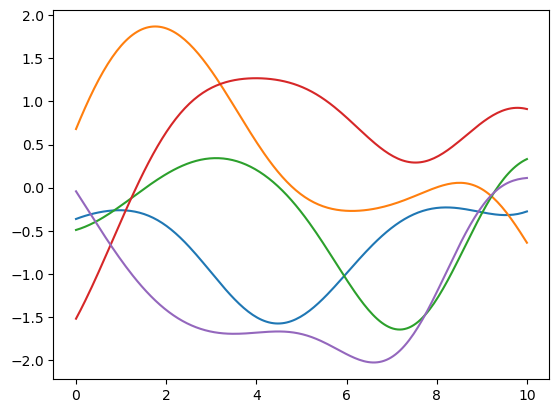

In [71]:
x = np.linspace(0, 10, 200)  # a fixed set of x's, 200 of them. 
cov = pm.gp.cov.ExpQuad(1, ls=2) # a covariance *function*
K_xx = cov(x[:, None]).eval() # evaluate the covariance function over the fixed set of x's, now it's a matrix K_xx
f_x = pm.draw(pm.MvNormal.dist(mu=np.zeros(200), cov=K_xx), 5)  # draw 5 samples of the GP over the fixed set of x's

plt.plot(x, f_x.T);

And now, let's fit our first GP -- **and** let's get some predictions.  Let's use the example from earlier, where we technically we did fit a GP -- but without making predictions at arbitrary $x$.  Let's consider two regions of the domain $x$.  The first is where our data is, this is `x` in the code below.  We'll denote where we want predictions as `xs`.  

## GP Posterior

In [72]:
x = 5 * np.sort(np.random.rand(100))
xs = np.linspace(np.max(x), 10, 100)
x_both = np.concatenate((x, xs))

with pm.Model() as model:
    # Since we don't know them, we put distributions on the parameters of the kernel, like the lengthscale
    eta = pm.HalfNormal("eta", sigma=1)
    lengthscale = pm.Uniform("lengthscale", lower=1, upper=5)
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=lengthscale)
  
    ## All that math can be written in a couple lines of code
    gp = pm.gp.Latent(cov_func=cov_func)
    f = gp.prior("f", X=x_both[:, None])
    
    p = pm.Deterministic("p", at.sigmoid(f))
    # index just the data points into the likelihood
    p = p[:len(x)]
    lik = pm.Bernoulli("lik", p=p, observed=y)

with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(target_accept=0.9)

Compiling...
Compilation time =  0:00:03.862531
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:03:14.510330
Transforming variables...
Transformation time =  0:00:08.959489
Computing Log Likelihood...
Log Likelihood time =  0:00:06.920791


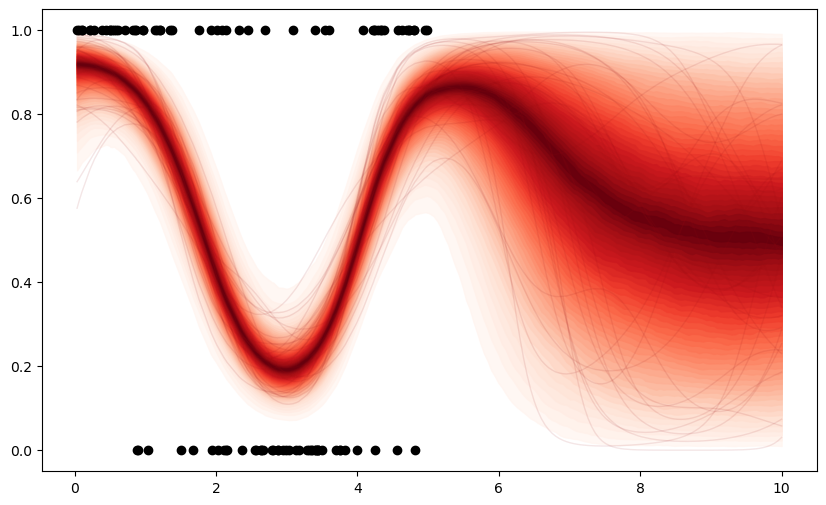

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

p = idata.posterior.p.stack(samples=['chain', 'draw']).values

pm.gp.util.plot_gp_dist(ax, p.T, x=x_both)
plt.plot(x, y, "ok");

It may seem like a minor detail, or an issue about semantics, but the idea of functions over arbitrary x, and a fixed set of x's, is key to what sets GP's apart.  Also notice that we have to fit and predict at the same time.  To do so, we just index our GP points where we have observed data at, the rest are our predictions.

This is what makes GPs such effective modeling tools -- they are extremely expressive.  Remember the line and cosine model we first tried to use to fit the Mauna Loa data set?  GPs are distribution over functions that are defined by the idea of similarity, instead of parameters like slope and y-intercept, or frequency, amplitude and phase.  This is why they are called **non-parametric** models, while models like the line and cosine model are called **parametric** models.  Non-parametric models generally need the whole training data set on hand to make predictions, which is technically true for GPs as well, as we'll see in the next section.  We won't worry too much about the distinction in this course, but you will see these terms around in other places, so this is what they mean.  

# Sec 80: Conclusion

And that's the basics of GPs! GPs can be boiled down to the sum of two main ingredients, kernels and multivariate Gaussians.  You may have already noticed though that sampling is a bit slow.  This would be foreshadowing for what happens next...  If you take away two things from this course, it should be:

1.  At their core, GPs are simple, and elegent.  You can model many, many kinds of random functions as giant multivariate normal distributions, with a kernel function for the covariance.  The kernel function you use determines the model.  
2.  Scaling GPs to larger data sets is **hard**.  It's not an exaggeration to say that for everything you'll learn about GPs (other than the behaviors of different kernel functions) is about scaling GPs to larger data sets, and making them run faster, and just making them practically usable.
3.  In order for GPs to be usable in all but the simplest cases, you need to fit and predict as a two step process.  We'll show how to do this in a later lesson, when we learn about conditioning and marginalization of multivariate normals.

For instance, in nearly any practical situation, you don't want to fit and predict all in one step, since fitting is so much slower.  The next lesson is about how to condition in GPs to make fitting and predicting a two step process.  Then, the lesson after that one is about the special case where the likelihood is also Gaussian, like in the Mauna Loa example above (but not like the logistic regression example).  There we can exploit something called *conjugacy* to avoid explicitly sampling the GP at the observed data $f$.  If it seems hard to imagine how that's possible, we'll explain later.

The point is, these two concepts are so important for using GPs in practice, that people often include them *when explaining what a GP even is* -- even though as you can see above, we "can" understand, fit, and predict with GPs without them.  

The rest of this course we'll gain a deeper understanding of GPs, challenges to using them in practice.  We'll cover many different type of kernels, beyond those we showed above.  We'll also cover a few very important GP approximations that you'll need when working with real data, at least if it has more than a couple hundred data points.  Most importantly, we'll learn about how to use GPs effectively to create **good** and useful models. 